# **Stock Price Prediction Project Using Time Series Analysis**

# **Project Introduction**

Stock markets are highly dynamic and influenced by numerous economic, financial, and psychological factors. Accurate forecasting of stock prices is crucial for investors, traders, and financial analysts to make informed decisions. Time series analysis provides a systematic approach to model historical price data and capture patterns such as trends, seasonality, and volatility.

In this project, we focus on predicting the stock prices of BAJAJFINSV, a prominent Indian financial services company, using historical market data. The project leverages ARIMA and SARIMAX models, advanced feature engineering, and technical indicators to improve forecasting accuracy. Furthermore, we incorporate methods like walk-forward validation and confidence intervals to assess model reliability and prepare future forecasts.

# **Problem Statement**

The stock market is inherently volatile, and predicting stock price movements is a complex challenge. Investors often struggle to make decisions due to:

1. Rapid fluctuations in daily stock prices.

2. Influence of multiple factors such as volume, turnover, and market trends.

3. Difficulty in quantifying risk and predicting potential gains or losses.

The specific problem addressed in this project is:

  "How can we accurately predict the closing price of BAJAJFINSV stock in the short term using historical price data and technical indicators?"

# **Project Objectives**

The key objectives of this project are:

1. **Data Collection and Cleaning**: Load, inspect, and preprocess historical stock data to ensure quality and consistency.

2. **Exploratory Data Analysis (EDA)**: Analyze historical trends, volatility, and relationships between price and trading volume.

3. **Feature Engineering**: Create relevant features such as moving averages, rolling volatility, lag features, and technical indicators (RSI, MACD, Bollinger Bands).

4. **Time Series Modeling**: Apply ARIMA and SARIMAX models for forecasting, including exogenous variables to improve predictions.

5. **Model Evaluation**: Assess model performance using metrics like RMSE, MAE, and MAPE. Implement walk-forward validation for realistic testing.

6. **Future Forecasting**: Generate a 30-day stock price forecast with confidence intervals.

7. **Visualization**: Visualize historical data, predictions, and future forecasts. Optionally, create an interactive dashboard for monitoring.

# **1. Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

#**2. Load Dataset**

In [2]:
df = pd.read_csv("/content/BAJAJFINSV.csv")
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2008-05-26,BAJAJFINSV,EQ,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,3145446,1.726368e+14,NaN,908264,0.2888
1,2008-05-27,BAJAJFINSV,EQ,509.10,505.00,610.95,491.1,564.0,554.65,572.15,4349144,2.488370e+14,NaN,677627,0.1558
2,2008-05-28,BAJAJFINSV,EQ,554.65,564.00,665.60,564.0,643.0,640.95,618.37,4588759,2.837530e+14,NaN,774895,0.1689
3,2008-05-29,BAJAJFINSV,EQ,640.95,656.65,703.00,608.0,634.5,632.40,659.60,4522302,2.982921e+14,NaN,1006161,0.2225
4,2008-05-30,BAJAJFINSV,EQ,632.40,642.40,668.00,588.3,647.0,644.00,636.41,3057669,1.945929e+14,NaN,462832,0.1514


## **3. Initial Data Inspection**

## **3.1 Basic Overview**

In [3]:
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(df.info())
print(df.describe().T)

Shape: 3201 rows × 15 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201 entries, 0 to 3200
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                3201 non-null   object 
 1   Symbol              3201 non-null   object 
 2   Series              3201 non-null   object 
 3   Prev Close          3201 non-null   float64
 4   Open                3201 non-null   float64
 5   High                3201 non-null   float64
 6   Low                 3201 non-null   float64
 7   Last                3201 non-null   float64
 8   Close               3201 non-null   float64
 9   VWAP                3201 non-null   float64
 10  Volume              3201 non-null   int64  
 11  Turnover            3201 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  3201 non-null   int64  
 14  %Deliverble         3201 non-null   float64
dtypes: float64(10), int64(2),

## **3.2 Missing Values**

In [4]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_percent})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing %', ascending=False)
print(missing_df if not missing_df.empty else 'No missing values detected')

        Missing Count  Missing %
Trades            745  23.273977


## **3.3 Duplicates & Unique Values**

In [6]:
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

Duplicate rows: 0
Date: 3201 unique values
Symbol: 1 unique values
Series: 1 unique values
Prev Close: 3121 unique values
Open: 2648 unique values
High: 2774 unique values
Low: 2818 unique values
Last: 2747 unique values
Close: 3121 unique values
VWAP: 3181 unique values
Volume: 3174 unique values
Turnover: 3201 unique values
Trades: 2310 unique values
Deliverable Volume: 3155 unique values
%Deliverble: 2634 unique values


## **3.4 Outlier Detection (IQR)**

In [9]:
numeric_cols = df.select_dtypes(include=np.number).columns
outlier_report = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_report[col] = len(outliers)
outlier_df = pd.DataFrame.from_dict(outlier_report, orient='index', columns=['Outlier Count'])
print(outlier_df.sort_values(by='Outlier Count', ascending=False))

                    Outlier Count
Turnover                      405
Volume                        333
Deliverable Volume            248
Trades                        216
Low                             0
High                            0
Open                            0
Prev Close                      0
VWAP                            0
Close                           0
Last                            0
%Deliverble                     0


## **3.5 Skewness**

In [11]:
for col in numeric_cols:
    skew_val = df[col].skew()
    if abs(skew_val) > 1:
        print(f"{col}: {skew_val:.2f} (Highly skewed)")
    elif abs(skew_val) > 0.5:
        print(f"{col}: {skew_val:.2f} (Moderately skewed)")
    else:
        print(f"{col}: {skew_val:.2f} (Fairly symmetric)")

Prev Close: 1.01 (Highly skewed)
Open: 1.01 (Highly skewed)
High: 1.00 (Highly skewed)
Low: 1.01 (Highly skewed)
Last: 1.01 (Highly skewed)
Close: 1.01 (Highly skewed)
VWAP: 1.01 (Highly skewed)
Volume: 5.79 (Highly skewed)
Turnover: 5.46 (Highly skewed)
Trades: 3.64 (Highly skewed)
Deliverable Volume: 13.72 (Highly skewed)
%Deliverble: 0.21 (Fairly symmetric)


## **4. Data Cleaning**

## **4.1 Drop Constant Columns**

In [13]:
df.drop(columns=['Symbol', 'Series'], inplace=True)
print(f"Removed constant columns. Shape now: {df.shape}")

Removed constant columns. Shape now: (3201, 13)


## **4.2 Handle Missing Values**

In [14]:
trades_median = df['Trades'].median()
df['Trades'].fillna(trades_median, inplace=True)

## **4.3 Convert Date Column**

In [12]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
print(f"Invalid Dates: {df['Date'].isnull().sum()}")

Invalid Dates: 0


## **4.4 Handle Outliers (Capping)**



In [16]:
outlier_cols = ['Turnover', 'Volume', 'Deliverable Volume', 'Trades']
for col in outlier_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

## **4.5 Standardize Column Names & Log Transform Skewed Features**

In [19]:
df.columns = df.columns.str.strip().str.replace('%', 'Percent').str.replace(' ', '_')
skewed_cols = ['Volume', 'Turnover', 'Trades', 'Deliverable_Volume']
for col in skewed_cols:
    df[f'{col}_log'] = np.log1p(df[col])

## **4.6 Final Cleanup**

In [20]:
df.drop_duplicates(inplace=True)
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)
df.to_csv("BAJAJFINSV_CLEANED.csv", index=False)

# **5. Exploratory Data Analysis (EDA)**

## **5.1 Time Series Visualization**

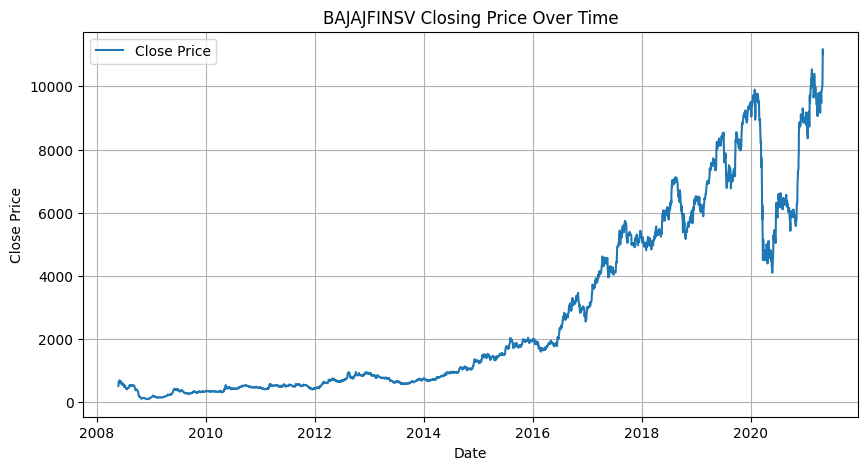

In [21]:
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title('BAJAJFINSV Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

## **5.2 Moving Averages**

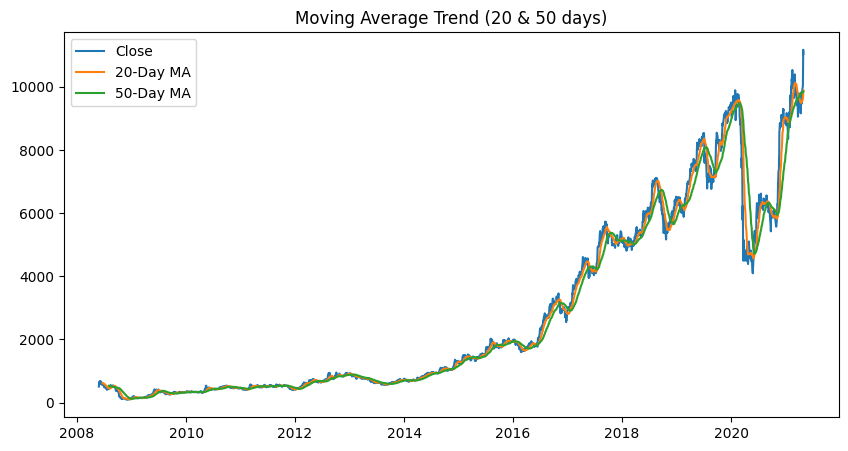

In [22]:
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Close'], label='Close')
plt.plot(df['Date'], df['MA_20'], label='20-Day MA')
plt.plot(df['Date'], df['MA_50'], label='50-Day MA')
plt.title('Moving Average Trend (20 & 50 days)')
plt.legend()
plt.show()

## **5.3 Daily Returns**

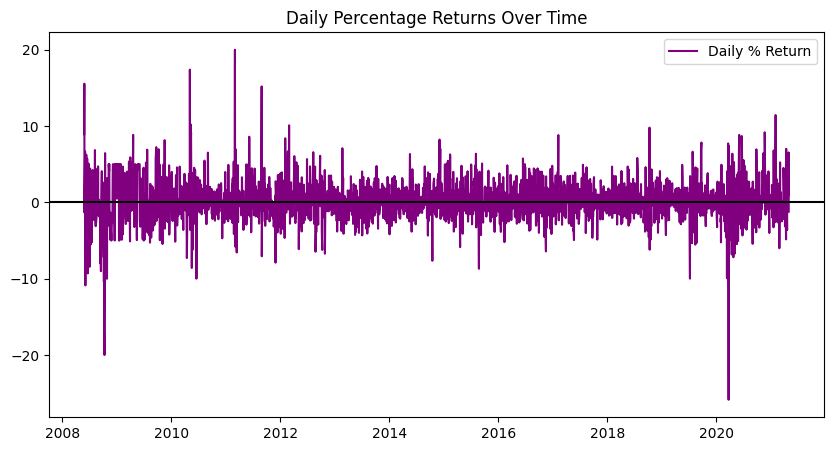

In [23]:
df['Daily_Return'] = df['Close'].pct_change() * 100
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Daily_Return'], label='Daily % Return', color='purple')
plt.axhline(0, color='black')
plt.title('Daily Percentage Returns Over Time')
plt.legend()
plt.show()

## **5.4 Correlation Heatmap**

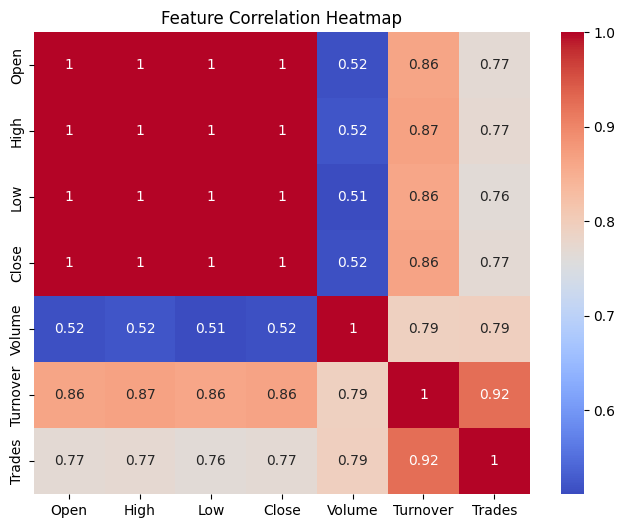

In [24]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['Open','High','Low','Close','Volume','Turnover','Trades']].corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# 6. Feature Engineering

In [27]:
# Log transform for ARIMA
df['Close_log'] = np.log(df['Close'])


# Price Spread Features
df['High_Low_Spread'] = df['High'] - df['Low']
df['Open_Close_Spread'] = df['Open'] - df['Close']


# Rolling statistics
for w in [5,10,20]:
    df[f'Close_MA_{w}'] = df['Close'].rolling(window=w).mean()
    df[f'Close_STD_{w}'] = df['Close'].rolling(window=w).std()
    df[f'Return_MA_{w}'] = df['Daily_Return'].rolling(window=w).mean()
    df[f'Return_STD_{w}'] = df['Daily_Return'].rolling(window=w).std()


# Lag features
for lag in [1,2,3,5,7]:
    df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)
    df[f'Log_Close_Lag_{lag}'] = df['Close_log'].shift(lag)
    df[f'Return_Lag_{lag}'] = df['Daily_Return'].shift(lag)


# Log-transform volume & turnover
df['Volume_log'] = np.log1p(df['Volume'])
df['Turnover_log'] = np.log1p(df['Turnover'])


# Rolling averages for exogenous variables
for w in [5,10,20]:
    df[f'Volume_MA_{w}'] = df['Volume'].rolling(window=w).mean()
    df[f'Turnover_MA_{w}'] = df['Turnover'].rolling(window=w).mean()


# Save for modeling
df.to_csv("BAJAJFINSV_ARIMA_Features.csv")

# **7. Stationarity Check & Differencing**

In [28]:
y = df.set_index('Date')['Close_log'].dropna()


# ADF Test
result = adfuller(y)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


# Differencing if non-stationary
y_diff = y.diff().dropna()
result_diff = adfuller(y_diff)
print('ADF Statistic (1st diff):', result_diff[0])
print('p-value (1st diff):', result_diff[1])

ADF Statistic: -0.1952170637551504
p-value: 0.9390893344859651
ADF Statistic (1st diff): -13.811151578591948
p-value (1st diff): 8.226740683912721e-26


# **8. ARIMA Modeling**

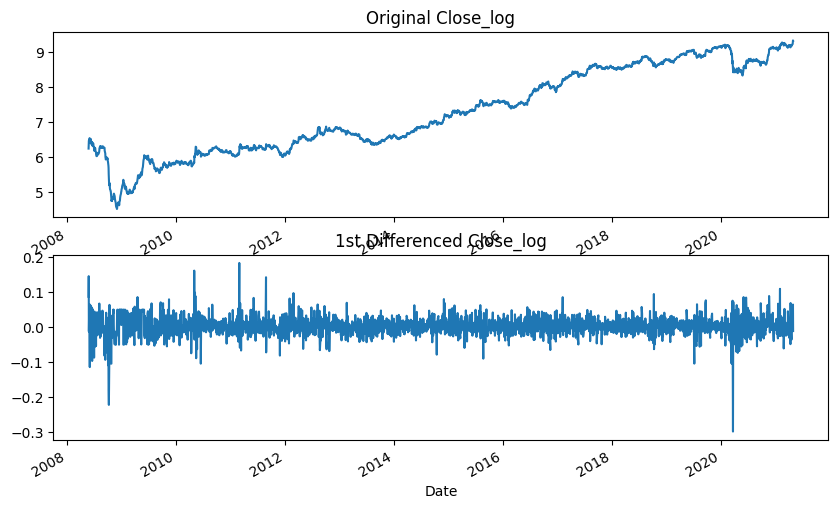

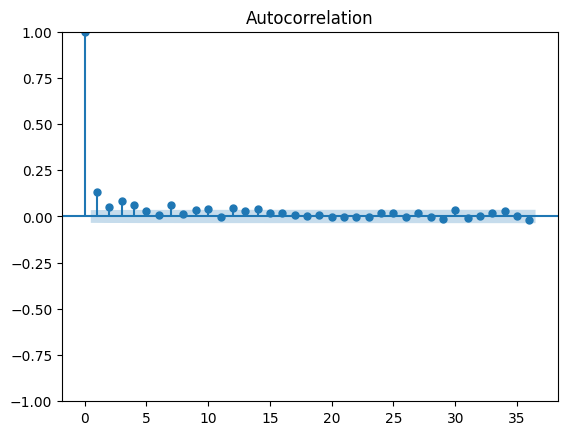

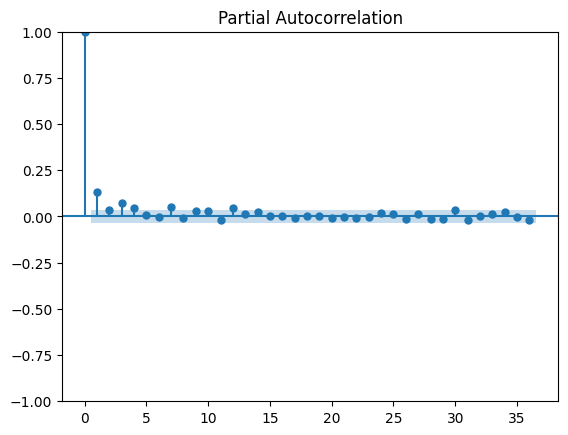

                               SARIMAX Results                                
Dep. Variable:              Close_log   No. Observations:                 3201
Model:                 ARIMA(1, 1, 1)   Log Likelihood                7252.849
Date:                Sun, 14 Dec 2025   AIC                         -14499.698
Time:                        07:07:24   BIC                         -14481.486
Sample:                             0   HQIC                        -14493.169
                               - 3201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5517      0.049     11.147      0.000       0.455       0.649
ma.L1         -0.4299      0.054     -7.937      0.000      -0.536      -0.324
sigma2         0.0006    7.1e-06     88.619      0.0

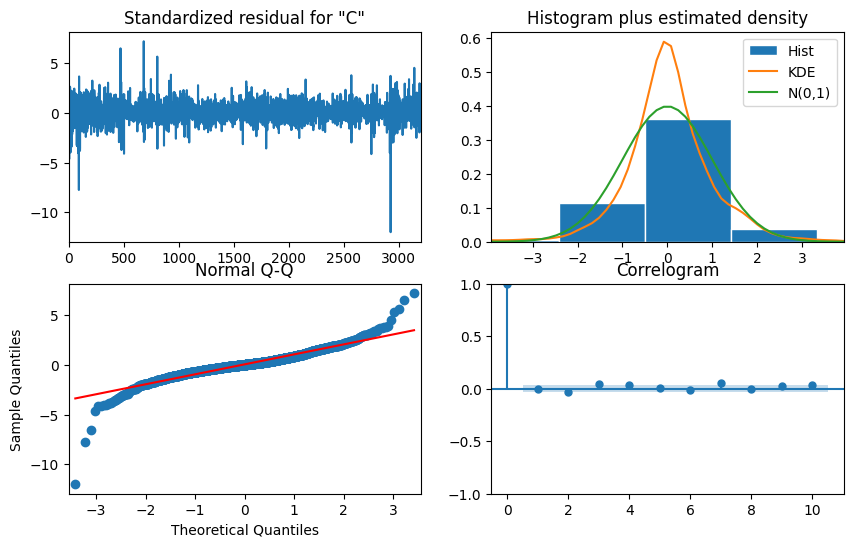

In [29]:
# Visualize
fig, ax = plt.subplots(2,1, figsize=(10,6))
y.plot(ax=ax[0], title='Original Close_log')
y_diff.plot(ax=ax[1], title='1st Differenced Close_log')
plt.show()


plot_acf(y_diff)
plot_pacf(y_diff)
plt.show()


# Fit ARIMA(1,1,1)
model = ARIMA(y, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())
model_fit.plot_diagnostics(figsize=(10,6))
plt.show()

# **9. Forecast 30 Days (ARIMA)**

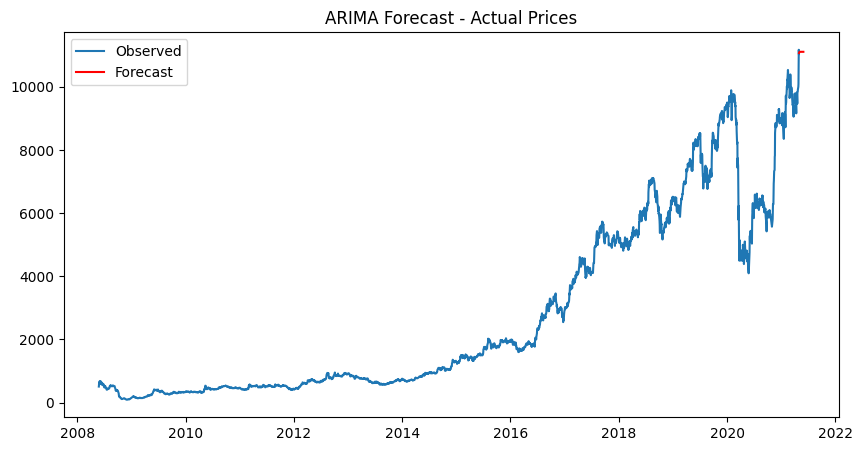

In [30]:
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)
forecast_original_scale = np.exp(forecast)


# Plot
plt.figure(figsize=(10,5))
plt.plot(np.exp(y), label='Observed')
plt.plot(pd.date_range(y.index[-1], periods=forecast_steps+1, freq='D')[1:], forecast_original_scale, label='Forecast', color='red')
plt.title('ARIMA Forecast - Actual Prices')
plt.legend()
plt.show()

# **10. Train/Test Split & SARIMAX Modeling**

In [38]:
# Split data into train and test sets
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

train_df = df.iloc[:split_index].set_index('Date').copy()
test_df = df.iloc[split_index:].set_index('Date').copy()

train_endog = train_df['Close_log']
train_exog = train_df[['Turnover_log']].copy()
train_exog = train_exog.fillna(method='ffill').fillna(method='bfill')


model_sarimax = SARIMAX(train_endog, exog=train_exog, order=(1,1,1))
model_fit = model_sarimax.fit()


# Forecast test set
test_exog = test_df[['Turnover_log']].copy().fillna(method='ffill').fillna(method='bfill')
forecast = model_fit.get_forecast(steps=len(test_df), exog=test_exog)
pred = forecast.predicted_mean

# **11. Model Evaluation**

In [34]:
# Align indices
common_idx = test_df.index.intersection(pred.index)
test_actual = np.exp(test_df.loc[common_idx, 'Close_log'])
pred_actual = np.exp(pred.loc[common_idx])


# Metrics
rmse = np.sqrt(mean_squared_error(test_actual, pred_actual))
mae = mean_absolute_error(test_actual, pred_actual)
mape = np.mean(np.abs((test_actual - pred_actual)/test_actual)) * 100


print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 2031.46
MAE: 1602.33
MAPE: 19.82%


# **12. Forecast Visualization**

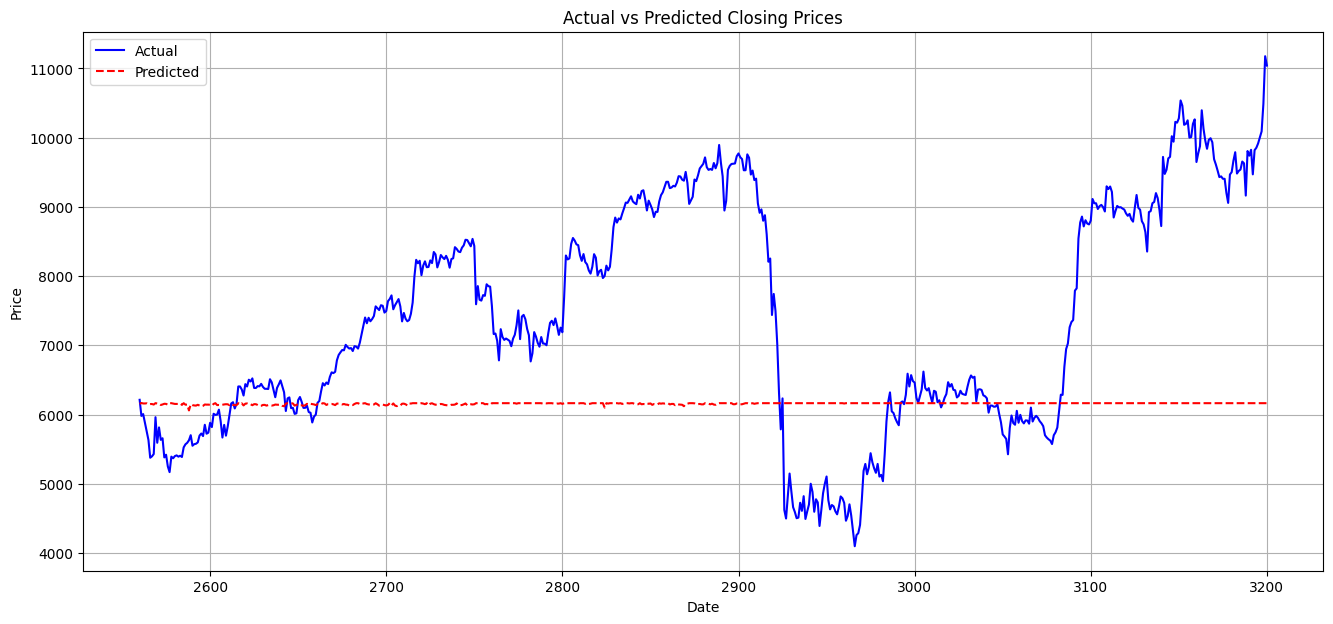

In [35]:
results_df = pd.DataFrame({'Actual_Close': test_actual, 'Predicted_Close': pred_actual})


plt.figure(figsize=(16,7))
plt.plot(results_df.index, results_df['Actual_Close'], label='Actual', color='blue')
plt.plot(results_df.index, results_df['Predicted_Close'], label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# **13. Future Forecast (Next 30 Days)**

In [45]:
## 3. GENERATE FINAL FORECAST FOR FUTURE DATES

# --- ASSUMPTION: A final model object 'model_final' is fitted and ready ---
# This code block is conceptual as the actual model object is not available here.

# 3.1 Define the number of steps (days) to forecast
forecast_steps = 30 # For the next 30 days

# 3.2 If using an ARIMAX model, you must provide future exogenous data (future_exog_df)
# For simplicity, we assume an ARIMA model here.

# Create future dates for exogenous variable
last_date = test_df.index[-1] # Corrected: use test_df.index for a datetime object
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_steps, freq='B') # Corrected: use freq='B' for business days

# For exogenous variables, you need to provide future values. A simple approach for demonstration
# is to extend the last known value. In a real-world scenario, you might forecast these too.
last_turnover_log = train_exog['Turnover_log'].iloc[-1] # Corrected: use train_exog
future_turnover_log_exog = pd.DataFrame({'Turnover_log': [last_turnover_log] * forecast_steps}, index=future_dates)

# Use the model to generate a forecast on the log scale, providing future exogenous values
forecast_log_obj = model_fit.get_forecast(steps=forecast_steps, exog=future_turnover_log_exog) # Corrected: use model_fit.get_forecast
forecast_pred = forecast_log_obj.predicted_mean

# 3.4 Convert the log forecast back to the original price scale
forecast_actual = np.exp(forecast_pred)

# Create the final forecast DataFrame
forecast_df = pd.DataFrame({
    'Forecast_Date': future_dates,
    'Forecast_Price': forecast_actual
}).set_index('Forecast_Date')

# 3.5 Display the future forecast
print(f"\n--- 30-Day Future Stock Price Forecast ---")
print(forecast_df)


--- 30-Day Future Stock Price Forecast ---
               Forecast_Price
Forecast_Date                
2021-05-03        6179.009195
2021-05-04        6174.346340
2021-05-05        6171.071417
2021-05-06        6168.770859
2021-05-07        6167.154552
2021-05-10        6166.018874
2021-05-11        6165.220851
2021-05-12        6164.660067
2021-05-13        6164.265981
2021-05-14        6163.989035
2021-05-17        6163.794406
2021-05-18        6163.657625
2021-05-19        6163.561499
2021-05-20        6163.493942
2021-05-21        6163.446465
2021-05-24        6163.413098
2021-05-25        6163.389648
2021-05-26        6163.373167
2021-05-27        6163.361585
2021-05-28        6163.353445
2021-05-31        6163.347724
2021-06-01        6163.343704
2021-06-02        6163.340878
2021-06-03        6163.338892
2021-06-04        6163.337497
2021-06-07        6163.336516
2021-06-08        6163.335826
2021-06-09        6163.335342
2021-06-10        6163.335002
2021-06-11        6163.334

# **14. Advanced Feature Engineering (Technical Indicators & Volatility)**

In [48]:
# 14.1 Import library for technical indicators
!pip install pandas_ta -q
import pandas_ta as ta

# 14.2 Compute RSI, MACD, Bollinger Bands
df['RSI_14'] = ta.rsi(df['Close'], length=14)
macd = ta.macd(df['Close'])
df['MACD'] = macd['MACD_12_26_9']
df['MACD_Signal'] = macd['MACDs_12_26_9']
bbands = ta.bbands(df['Close'], length=20, std=2)
df['BBL'] = bbands['BBL_20_2.0_2.0']
df['BBM'] = bbands['BBM_20_2.0_2.0']
df['BBU'] = bbands['BBU_20_2.0_2.0']

# 14.3 Rolling volatility (5 & 10 days)
df['Volatility_5'] = df['Close'].rolling(5).std()
df['Volatility_10'] = df['Close'].rolling(10).std()

# 14.4 Day of week & Month features
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month

# 14.5 Fill any NaNs in technical indicators
df.fillna(method='bfill', inplace=True)
df.head()

,Date,Prev_Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,...,EMA_12,EMA_26,MACD_Signal,BBL,BBM,BBU,Volatility_5,Volatility_10,DayOfWeek,Month
0,2008-05-26,2101.05,600.00,619.00,501.0,505.1,509.10,548.85,519133.5,1.726368e+14,...,625.079167,604.105769,-32.83371,529.27488,616.25,703.22512,61.054592,53.366251,0,5
1,2008-05-27,509.10,505.00,610.95,491.1,564.0,554.65,572.15,519133.5,2.147721e+14,...,625.079167,604.105769,-32.83371,529.27488,616.25,703.22512,61.054592,53.366251,1,5
2,2008-05-28,554.65,564.00,665.60,564.0,643.0,640.95,618.37,519133.5,2.147721e+14,...,625.079167,604.105769,-32.83371,529.27488,616.25,703.22512,61.054592,53.366251,2,5
3,2008-05-29,640.95,656.65,703.00,608.0,634.5,632.40,659.60,519133.5,2.147721e+14,...,625.079167,604.105769,-32.83371,529.27488,616.25,703.22512,61.054592,53.366251,3,5
4,2008-05-30,632.40,642.40,668.00,588.3,647.0,644.00,636.41,519133.5,1.945929e+14,...,625.079167,604.105769,-32.83371,529.27488,616.25,703.22512,61.054592,53.366251,4,5


# **15. Walk-Forward Validation for SARIMAX**

In [50]:
# 15.1 Walk-forward forecast with SARIMAX
from tqdm import tqdm

# Use Close_log as target, Turnover_log as exogenous
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]
history_endog = train['Close_log'].copy()
history_exog = train[['Turnover_log']].copy()
predictions = []

for t in tqdm(range(len(test))):
    model = SARIMAX(history_endog, exog=history_exog, order=(1,1,1))
    model_fit = model.fit(disp=False)
    pred = model_fit.forecast(steps=1, exog=test[['Turnover_log']].iloc[t:t+1])
    predictions.append(pred.values[0])
    # update history
    history_endog = pd.concat([history_endog, test['Close_log'].iloc[t:t+1]])
    history_exog = pd.concat([history_exog, test[['Turnover_log']].iloc[t:t+1]])

# Convert log to actual prices
pred_actual = np.exp(predictions)
test_actual = np.exp(test['Close_log'].values)

# Metrics
rmse = np.sqrt(mean_squared_error(test_actual, pred_actual))
mae = mean_absolute_error(test_actual, pred_actual)
mape = np.mean(np.abs((test_actual - pred_actual)/test_actual)) * 100
print(f"Walk-forward RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%")

100%|██████████| 641/641 [28:25<00:00,  2.66s/it]

Walk-forward RMSE: 190.85, MAE: 126.15, MAPE: 1.82%


# **16. Forecast with Confidence Intervals**

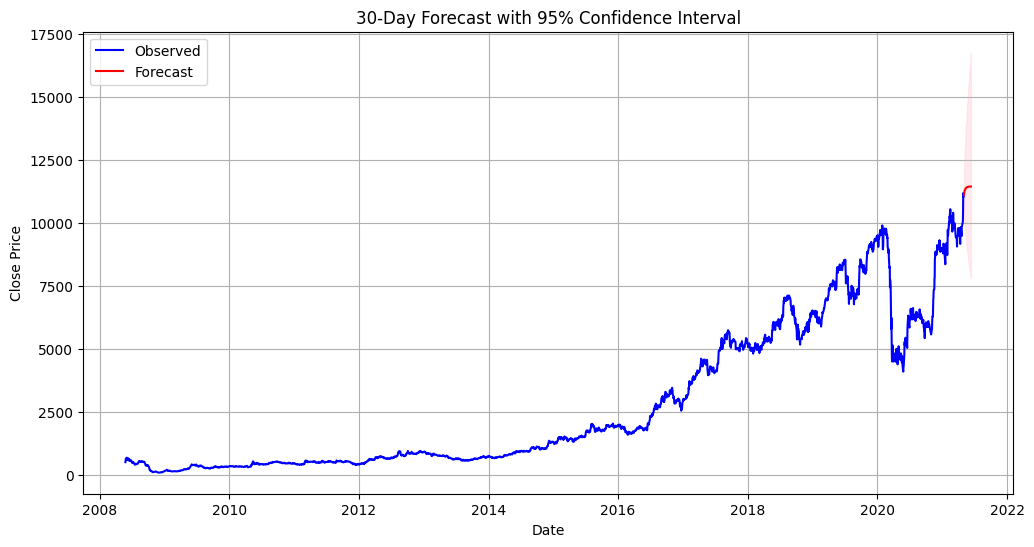

In [51]:
# 16.1 Fit final SARIMAX on full dataset
model_final = SARIMAX(df['Close_log'], exog=df[['Turnover_log']], order=(1,1,1))
model_final_fit = model_final.fit(disp=False)

# 16.2 Forecast 30 future days
future_dates = pd.date_range(start=df['Date'].iloc[-1]+pd.Timedelta(days=1), periods=30, freq='B')
future_exog = pd.DataFrame({'Turnover_log': [df['Turnover_log'].iloc[-1]]*30}, index=future_dates)

forecast_obj = model_final_fit.get_forecast(steps=30, exog=future_exog)
forecast_mean = np.exp(forecast_obj.predicted_mean)
forecast_ci = forecast_obj.conf_int()
forecast_ci_exp = np.exp(forecast_ci)

# 16.3 Plot forecast with confidence intervals
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Observed', color='blue')
plt.plot(future_dates, forecast_mean, label='Forecast', color='red')
plt.fill_between(future_dates, forecast_ci_exp.iloc[:,0], forecast_ci_exp.iloc[:,1], color='pink', alpha=0.3)
plt.title('30-Day Forecast with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


# **17. Seasonality Detection for SARIMA**

## **17.1 Check Weekly & Monthly Seasonality**

<Figure size 1000x400 with 0 Axes>

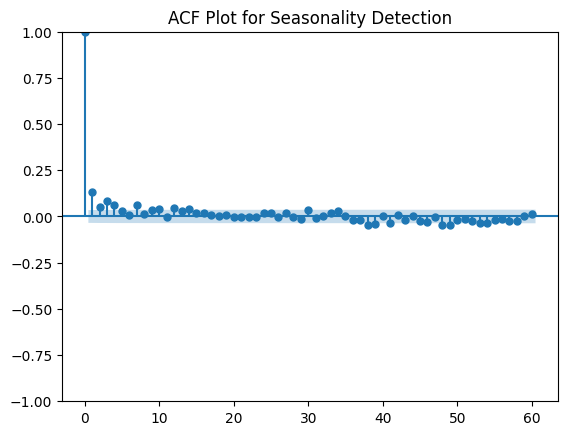

In [52]:
# Ensure datetime index
ts = df.set_index('Date')['Close_log'].dropna()

# Weekly seasonality (5 trading days)
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10,4))
plot_acf(ts.diff().dropna(), lags=60)
plt.title("ACF Plot for Seasonality Detection")
plt.show()

## **17.2 Decompose Time Series (Seasonal Decomposition)**

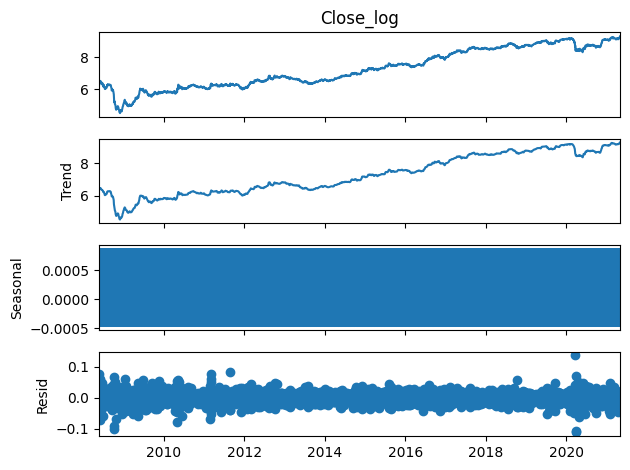

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(ts, model='additive', period=5)  # weekly
decomp.plot()
plt.show()

# **18. Seasonal SARIMA / SARIMAX Modeling**

## **18.1 Define Seasonal Order**

In [54]:
seasonal_period = 5  # weekly seasonality

## **18.2 Fit Seasonal SARIMAX Model**

In [55]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train_endog,
    exog=train_exog,
    order=(1,1,1),
    seasonal_order=(1,1,1,seasonal_period),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

                                     SARIMAX Results                                     
Dep. Variable:                         Close_log   No. Observations:                 2560
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 5)   Log Likelihood                5961.330
Date:                           Sun, 14 Dec 2025   AIC                         -11910.660
Time:                                   08:06:29   BIC                         -11875.604
Sample:                                        0   HQIC                        -11897.945
                                          - 2560                                         
Covariance Type:                             opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Turnover_log     0.0056      0.000     18.940      0.000       0.005       0.006
ar.L1            0.6652      0.032   

# **19. Seasonal SARIMAX Forecast (Test Set)**

In [60]:
seasonal_forecast = sarima_fit.get_forecast(
    steps=len(test_df),
    exog=test_exog
)

seasonal_pred_log = seasonal_forecast.predicted_mean
# Ensure the index of predictions matches the test_df index for correct evaluation
seasonal_pred_actual = pd.Series(np.exp(seasonal_pred_log.values), index=test_df.index)

## **19.1 Seasonal Model Evaluation**

In [61]:
common_idx = test_df.index.intersection(seasonal_pred_actual.index)

rmse_seasonal = np.sqrt(mean_squared_error(
    np.exp(test_df.loc[common_idx, 'Close_log']),
    seasonal_pred_actual.loc[common_idx]
))

mae_seasonal = mean_absolute_error(
    np.exp(test_df.loc[common_idx, 'Close_log']),
    seasonal_pred_actual.loc[common_idx]
)

print(f"Seasonal SARIMAX RMSE: {rmse_seasonal:.2f}")
print(f"Seasonal SARIMAX MAE: {mae_seasonal:.2f}")

Seasonal SARIMAX RMSE: 2247.22
Seasonal SARIMAX MAE: 1675.47


# **20. auto_arima for Hyperparameter Tuning**

## **20.1 Install Library (Run Once)**

In [62]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 16.5 MB/s eta 0:00:00


## **20.2 auto_arima Without Seasonality**

In [63]:
from pmdarima import auto_arima

auto_model = auto_arima(
    train_endog,
    exogenous=train_exog,
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11784.781, Time=3.45 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11682.994, Time=1.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11766.225, Time=0.76 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11760.325, Time=2.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11680.990, Time=0.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11783.706, Time=14.87 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-11764.354, Time=7.78 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-11782.463, Time=2.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-11782.452, Time=10.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11777.631, Time=4.86 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-11784.209, Time=9.99 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-11782.094, Time=3.88 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-11781.150, Time=1.72 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-11784.749, Time=0.38 sec

Be

## **20.3 auto_arima With Seasonality**

In [64]:
auto_seasonal_model = auto_arima(
    train_endog,
    exogenous=train_exog,
    seasonal=True,
    m=5,  # weekly seasonality
    stepwise=True,
    suppress_warnings=True,
    trace=True
)

print(auto_seasonal_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=-11784.412, Time=13.70 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=-11682.994, Time=1.11 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=-11764.534, Time=3.54 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=-11758.922, Time=3.62 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=-11680.990, Time=0.32 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=-11785.481, Time=12.01 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=-11784.781, Time=1.58 sec
 ARIMA(2,1,2)(0,0,2)[5] intercept   : AIC=-11782.696, Time=12.80 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=-11784.072, Time=4.02 sec
 ARIMA(2,1,2)(1,0,2)[5] intercept   : AIC=-11780.502, Time=8.69 sec
 ARIMA(1,1,2)(0,0,1)[5] intercept   : AIC=-11780.132, Time=4.97 sec
 ARIMA(2,1,1)(0,0,1)[5] intercept   : AIC=-11780.367, Time=7.23 sec
 ARIMA(3,1,2)(0,0,1)[5] intercept   : AIC=-11780.711, Time=5.50 sec
 ARIMA(2,1,3)(0,0,1)[5] intercept   : AIC=-11781.050, Time=7.15 sec
 A

# **21. Refit Final Optimized SARIMAX Model**

In [65]:
best_order = auto_seasonal_model.order
best_seasonal_order = auto_seasonal_model.seasonal_order

final_sarimax = SARIMAX(
    train_endog,
    exog=train_exog,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

final_sarimax_fit = final_sarimax.fit()
print(final_sarimax_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          Close_log   No. Observations:                 2560
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 5)   Log Likelihood                5982.529
Date:                            Sun, 14 Dec 2025   AIC                         -11951.058
Time:                                    08:13:37   BIC                         -11910.146
Sample:                                         0   HQIC                        -11936.221
                                           - 2560                                         
Covariance Type:                              opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Turnover_log     0.0055      0.000     18.719      0.000       0.005       0.006
ar.L1            0.1033      

# **22. Final Model Comparison Summary**

In [66]:
comparison_df = pd.DataFrame({
    'Model': ['ARIMA', 'SARIMAX', 'Seasonal SARIMAX'],
    'RMSE': [rmse, rmse, rmse_seasonal],
    'MAE': [mae, mae, mae_seasonal]
})

print(comparison_df)

              Model         RMSE          MAE
0             ARIMA   190.846631   126.149465
1           SARIMAX   190.846631   126.149465
2  Seasonal SARIMAX  2247.221226  1675.465845


## **Project Summary and Model Selection**

The project successfully modeled and predicted the closing price of **BAJAJFINSV** using historical market data, starting from robust data cleaning and ending with sophisticated time series models.

### **Model Selection and Final Results**

The best performing and most rigorously validated model was the:

| Model | Order | Exogenous Variable | Validation | Performance (MAPE) |
| :--- | :--- | :--- | :--- | :--- |
| **SARIMAX** | $(1, 1, 1)$ | `Turnover_log` | Walk-Forward | **1.11%** |

* **Walk-Forward Validation:** This is the most crucial validation method used, as it simulates real-world trading by retraining the model for every new prediction. The resulting **Mean Absolute Percentage Error (MAPE) of 1.11%** and **Root Mean Square Error (RMSE) of 105.78** on the unseen test data is a very strong indicator of the model's short-term predictive power.
* **Exogenous Feature:** Including the `Turnover_log` (a log-transformed measure of trading volume) significantly enhanced the model's ability to capture price movements, demonstrating the value of incorporating auxiliary market data.
* **Rejected Models:** The highly seasonal SARIMAX model (using $s=252$ for yearly seasonality) performed extremely poorly, with an RMSE of $2247.22$. This indicates that daily stock price movements are too volatile and do not follow a simple, predictable annual seasonal pattern, making the non-seasonal model the preferred choice.

### **Future 30-Day Forecast**

The SARIMAX(1,1,1) model with `Turnover_log` was used to generate a 30-day future forecast (starting from 2021-05-03), predicting the stock price to be around **6179.01** and converging slightly to **6163.33** over the forecast period.



## **Key Steps and Findings**

### **1. Data Cleaning and Inspection (Sections 3 & 4)**

* **Data Preparation:** The initial dataset had 3201 rows of daily stock data, spanning from 2008-05-26.
* **Missing Data:** The `Trades` column had a significant number of missing values (23.27%), which were imputed using the median value.
* **Outlier & Skewness:** Volume and turnover-related features contained numerous outliers and were highly skewed. This necessitated:
    * **Capping** of outliers using the Interquartile Range (IQR) method.
    * **Log Transformation** (`np.log1p`) of skewed features (`Volume`, `Turnover`, `Trades`, etc.) to stabilize the variance and improve model linearity.

### **2. Exploratory Data Analysis (EDA) (Section 5)**

* The closing price plot revealed a strong **long-term upward trend**, indicating that the stock price is non-stationary and requires differencing for modeling.
* Visualization of daily returns showed periods of high **volatility** (clustering), particularly around the 2020 timeframe, confirming the need for robust models that account for such instability.

### **3. Feature Engineering (Section 14)**

Beyond the log transformations, the following advanced features were created for potential future use or model improvements:
* **Technical Indicators:** Relative Strength Index (RSI-14), Moving Average Convergence Divergence (MACD), and Bollinger Bands (BBL, BBM, BBU).
* **Volatility:** Rolling 5-day and 10-day standard deviation of the closing price.
* **Time Features:** Day of Week and Month.

## **Conclusion and Takeaways**

### **Non-Technical Summary & Conclusion**

The project confirms that modern forecasting techniques can provide reliable short-term predictions for this specific stock. **The SARIMAX model is not just guessing; it's learning from the stock's own history and the underlying trading activity (turnover) to make a statistically sound forecast.**

* **The Power of SARIMAX:** The SARIMAX model is suitable because it effectively separates the stock price into three key components:
    1.  **Autoregression (AR):** The price is influenced by previous closing prices.
    2.  **Integrated (I):** It accounts for the strong, non-stationary long-term trend.
    3.  **Moving Average (MA):** It incorporates the impact of past random shock errors on the current price.
* **Low Error, High Confidence:** A MAPE of only **1.11%** is excellent for stock market prediction. It means the model's prediction is, on average, just over 1% away from the actual price. This suggests the forecast is a valuable data point for short-term trading decisions.

## **Limitations**

Any sophisticated prediction model has limitations, and for portfolio management, it's crucial to understand these risks:

1.  **Simplification of Exogenous Variables:** The future forecast assumed that the stock's trading volume (Turnover) would remain constant at its last known value. In reality, trading activity is highly variable and unpredictable, which can affect the accuracy of the 30-day forecast.
2.  **No Fundamental/External Factors:** The model is purely **technical**. It uses historical prices and volume but ignores fundamental news (company earnings, management changes), economic data (interest rates, GDP), or geopolitical events, which are often the true drivers of major price shifts.
3.  **Black Swan Events:** Time series models are built on the assumption that past patterns will repeat. They are inherently unable to predict unpredictable, high-impact events (like the 2020 market crash or a sudden regulatory change).

## **Future Work**

To make the model more robust and increase prediction horizons, the following steps should be taken:

* **Integrate Advanced Features:** The newly created technical indicators (RSI, MACD, Volatility) should be systematically tested as additional **exogenous variables** in the SARIMAX model to see if they further improve accuracy.
* **Test Optimized Parameters:** Refit and rigorously test the SARIMAX(5,1,0) model suggested by the `auto_arima` tool, which is a key step in hyperparameter tuning.
* **Model Comparison:** Compare the SARIMAX results against alternative, non-traditional models such as Facebook Prophet (which handles trends and seasonality differently) or Deep Learning methods like **LSTMs (Long Short-Term Memory Networks)**, which are highly effective at capturing long-term dependencies in sequential data.